In [3]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Used Bayesian inference to infer the parameters of a (linearised) gLV model

The generalized Lotka-Volterra equation takes the form

$$ \frac{dX_i}{dt} = \mu_i X_i + X_i M_{ij} X_j + X_i \epsilon_{il} u_l $$

where:
-   $X_i$ is the concentration of a species
-   $\mu_i$ is its specific growth rate
-   $M_{ij}$ is the effect of the interaction of species $i$ on species $j$
-   $\epsilon_{il}$ is the susceptibility to the time-dependent perturbation $u_l$

### Five species, single time course

(5,)
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: []
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}


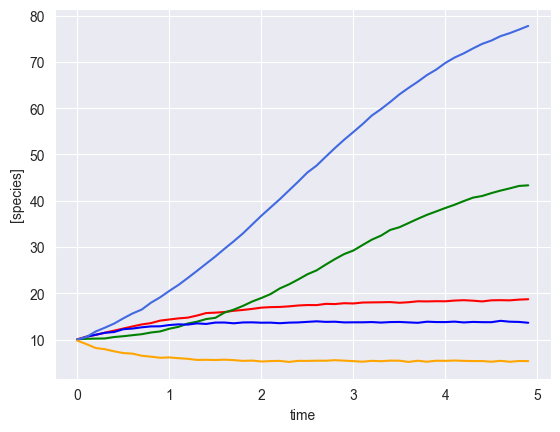

In [4]:
# In this example n >> p and it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)
print(mu.shape)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

### Bayesian inference (no shrinkage)
First we will do Bayesian inference without any shrinkage priors

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


In [6]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F.shape)

print(F[:10,:])


(49, 6)
(49, 5)
[[ 0.52895036  0.08536993  0.68020563  0.56929112 -0.80133732]
 [ 0.36152371  0.04655615  0.38556959  1.05386249 -0.96717332]
 [ 0.41594142  0.03248581  0.37166766  0.67425061 -0.3271869 ]
 [ 0.37814123  0.29460925  0.14918686  0.67619656 -0.59925564]
 [ 0.37527599  0.1640331   0.50946111  0.80951352 -0.50752239]
 [ 0.36122979  0.2060925   0.11214721  0.69562975 -0.18823973]
 [ 0.32668768  0.19299652  0.21482467  0.52364284 -0.66624361]
 [ 0.21463664  0.3216537   0.15238115  0.85808323 -0.30829425]
 [ 0.388769    0.19969247  0.01714542  0.63129112 -0.3851611 ]
 [ 0.17175939  0.48660706  0.20994262  0.69867514  0.11979933]]


X shape: (49, 6)
F shape: (49, 5)
Number of species: 5
Used manually determined mu
Used manually determined M
mu_hat: [[1.68699118 0.87136659 1.92468668 1.21378779 1.3581168 ]]
M_hat_vals: [[ 0.13109369 -0.18759855 -0.1159513  -0.01149945  0.15501878]
 [-0.10536638 -0.08473048  0.06543578 -0.02929615 -0.08466747]
 [-0.08160236  0.03443873  0.17297599  0.04773488 -0.19871444]
 [-0.02307457  0.11286627  0.16773507 -0.17382467 -0.17822255]
 [-0.1307444   0.0309186   0.02559513  0.05411776  0.18420972]]
M_hat: [[ 0.13109369 -0.18759855 -0.1159513  -0.01149945  0.15501878]
 [-0.10536638 -0.08473048  0.06543578 -0.02929615 -0.08466747]
 [-0.08160236  0.03443873  0.17297599  0.04773488 -0.19871444]
 [-0.02307457  0.11286627  0.16773507 -0.17382467 -0.17822255]
 [-0.1307444   0.0309186   0.02559513  0.05411776  0.18420972]]
model mean before: [[-3.72896277e-01 -1.02563075e-01  5.06144409e+00  6.71248009e-02
   1.11888342e-01]
 [-2.82334085e-01 -1.45756595e-01  5.20354621e+00 -5.09085623e-02
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_0_0_hat_prior, M_0_1_hat_prior, M_0_2_hat_prior, M_0_3_hat_prior, M_0_4_hat_prior, M_1_0_hat_prior, M_1_1_hat_prior, M_1_2_hat_prior, M_1_3_hat_prior, M_1_4_hat_prior, M_2_0_hat_prior, M_2_1_hat_prior, M_2_2_hat_prior, M_2_3_hat_prior, M_2_4_hat_prior, M_3_0_hat_prior, M_3_1_hat_prior, M_3_2_hat_prior, M_3_3_hat_prior, M_3_4_hat_prior, M_4_0_hat_prior, M_4_1_hat_prior, M_4_2_hat_prior, M_4_3_hat_prior, M_4_4_hat_prior]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 289 seconds.


mu_hat_np shape: (5,)
M_hat_np shape: (5, 5)


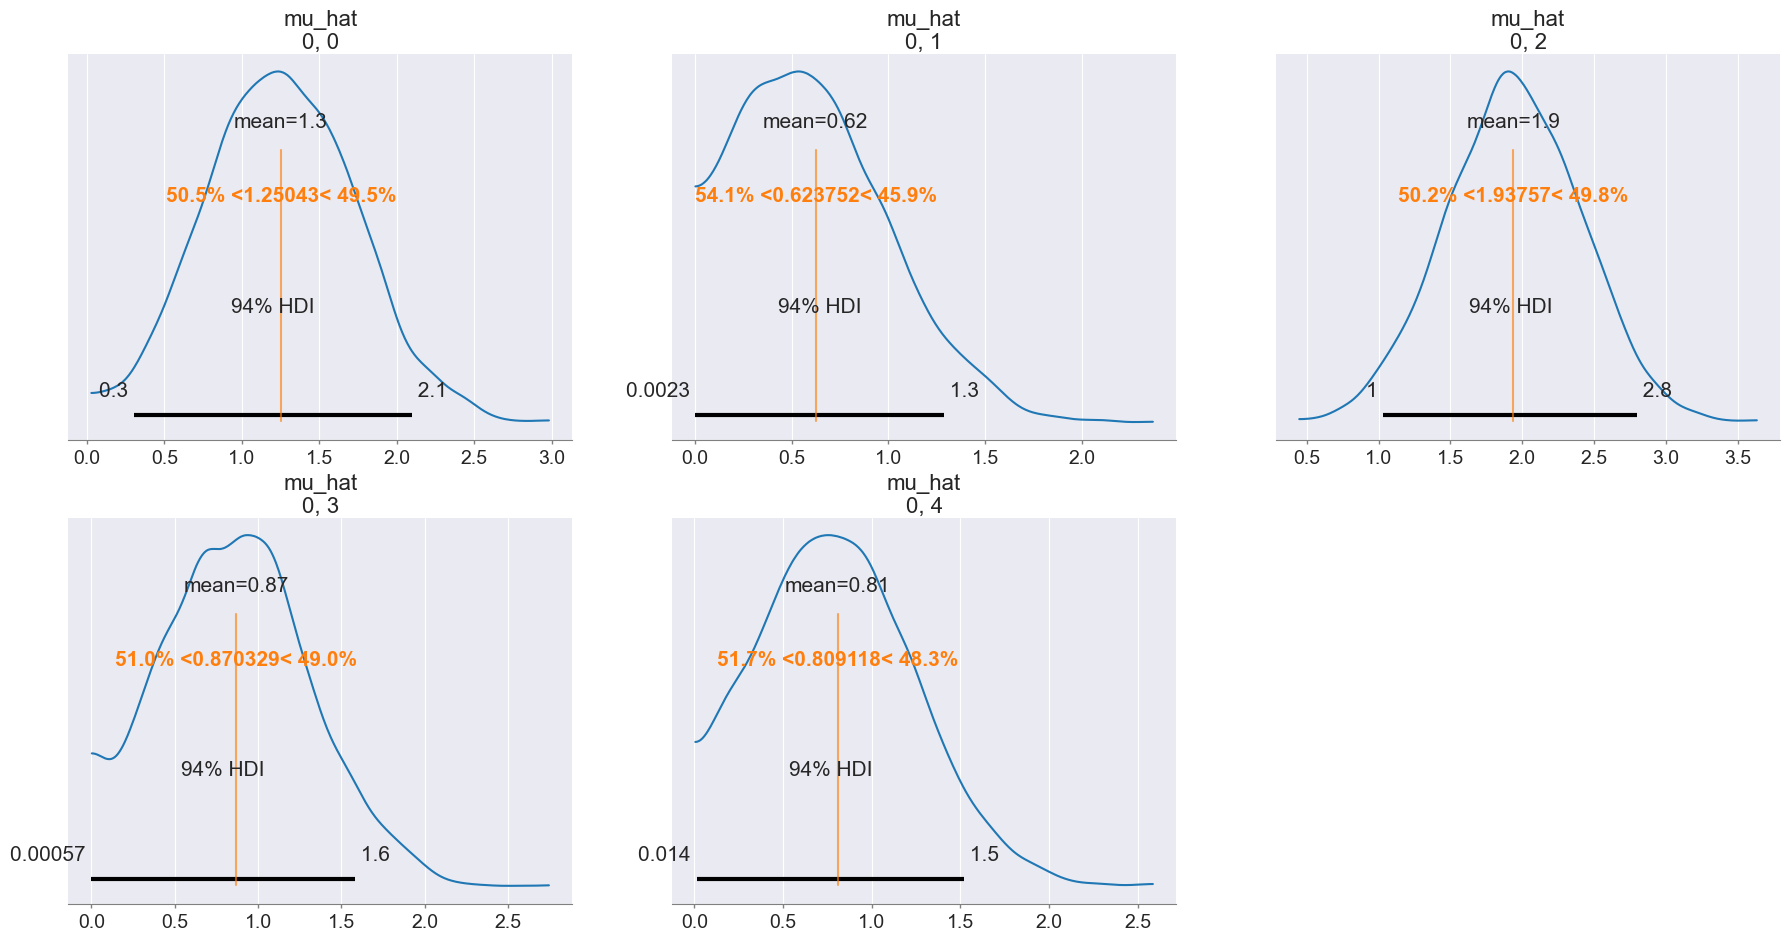

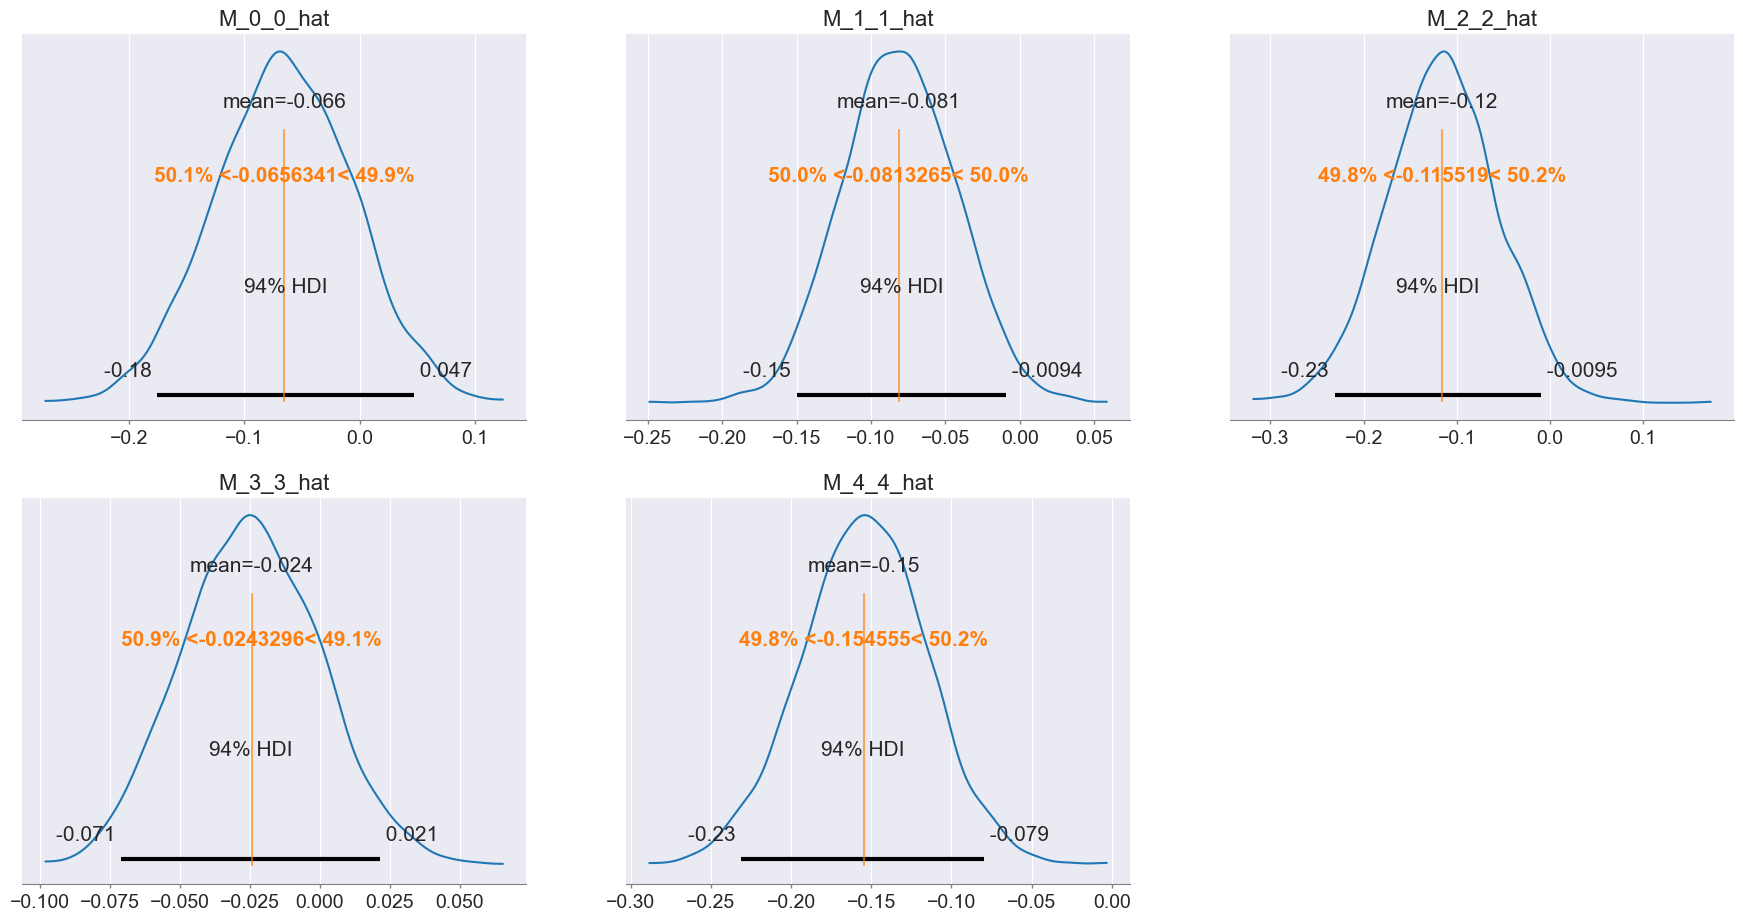

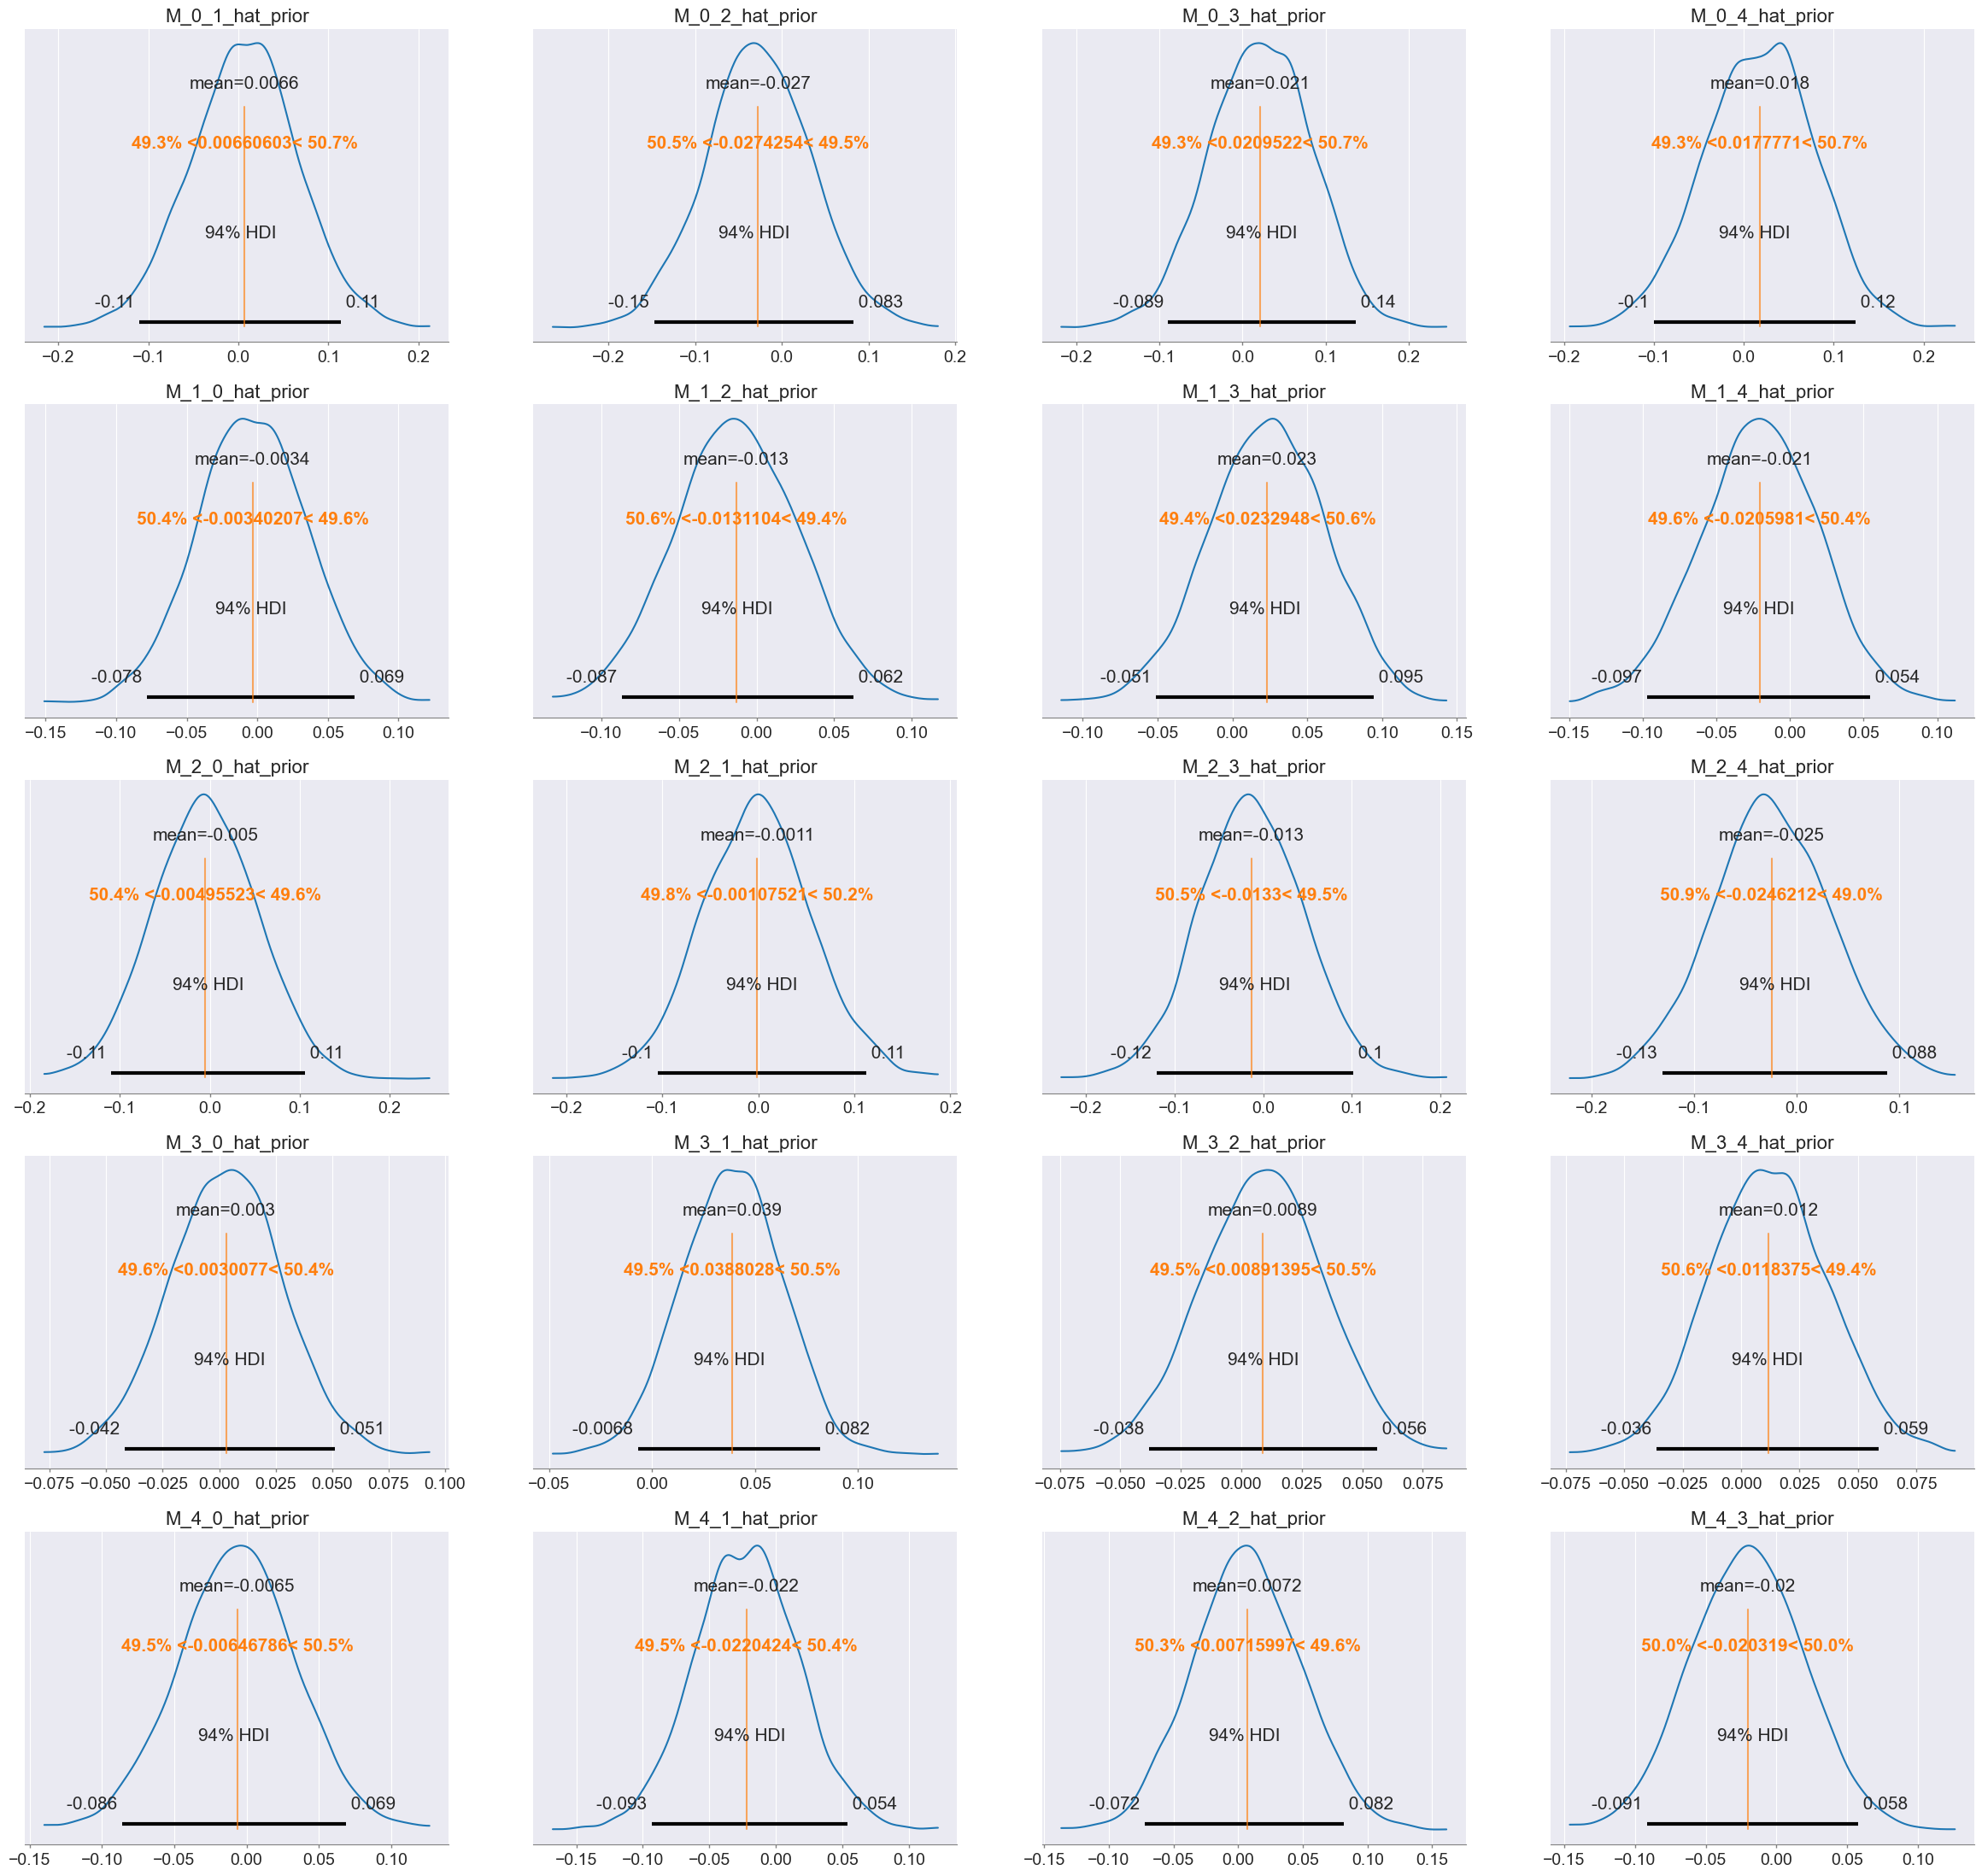

idata type after posterior extraction: <class 'arviz.data.inference_data.InferenceData'>


In [15]:
# Perform Bayesian inference

inference = infergLVbayes(X, F, mu, M)
idata, var_names = inference.run_bayes_gLV_test()

In [16]:
print(var_names)

['M_0_0_hat', 'M_1_1_hat', 'M_2_2_hat', 'M_3_3_hat', 'M_4_4_hat', 'M_0_1_hat_prior', 'M_0_2_hat_prior', 'M_0_3_hat_prior', 'M_0_4_hat_prior', 'M_1_0_hat_prior', 'M_1_2_hat_prior', 'M_1_3_hat_prior', 'M_1_4_hat_prior', 'M_2_0_hat_prior', 'M_2_1_hat_prior', 'M_2_3_hat_prior', 'M_2_4_hat_prior', 'M_3_0_hat_prior', 'M_3_1_hat_prior', 'M_3_2_hat_prior', 'M_3_4_hat_prior', 'M_4_0_hat_prior', 'M_4_1_hat_prior', 'M_4_2_hat_prior', 'M_4_3_hat_prior']


In [17]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_hat", "sigma"] + var_names)
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')



                  mean     sd  r_hat
mu_hat[0, 0]     1.250  0.479    1.0
mu_hat[0, 1]     0.624  0.384    1.0
mu_hat[0, 2]     1.938  0.471    1.0
mu_hat[0, 3]     0.870  0.438    1.0
mu_hat[0, 4]     0.809  0.430    1.0
M_hat[0, 0]     -0.066  0.059    1.0
M_hat[0, 1]      0.007  0.059    1.0
M_hat[0, 2]     -0.027  0.061    1.0
M_hat[0, 3]      0.021  0.061    1.0
M_hat[0, 4]      0.018  0.061    1.0
M_hat[1, 0]     -0.003  0.039    1.0
M_hat[1, 1]     -0.081  0.038    1.0
M_hat[1, 2]     -0.013  0.040    1.0
M_hat[1, 3]      0.023  0.039    1.0
M_hat[1, 4]     -0.021  0.040    1.0
M_hat[2, 0]     -0.005  0.058    1.0
M_hat[2, 1]     -0.001  0.057    1.0
M_hat[2, 2]     -0.116  0.060    1.0
M_hat[2, 3]     -0.013  0.059    1.0
M_hat[2, 4]     -0.025  0.058    1.0
M_hat[3, 0]      0.003  0.025    1.0
M_hat[3, 1]      0.039  0.024    1.0
M_hat[3, 2]      0.009  0.025    1.0
M_hat[3, 3]     -0.024  0.025    1.0
M_hat[3, 4]      0.012  0.025    1.0
M_hat[4, 0]     -0.006  0.041    1.0
M

'model_posterior.nc'

(4, 1000, 5, 5)
(4, 1000, 1, 5)
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.24541473, 0.58201275, 1.93437212, 0.86259363, 0.78628994]), 'M': array([[-0.06588318,  0.00743935, -0.02821227,  0.02225868,  0.01868926],
       [-0.00382617, -0.08131948, -0.01373837,  0.02410525, -0.02031291],
       [-0.00546718, -0.00076091, -0.11537494, -0.01407559, -0.02617002],
       [ 0.00316681,  0.0390869 ,  0.00931966, -0.02482803,  0.01139404],
       [-0.00607179, -0.02163312,  0.00680934, -0.0203775 , -0.15438959]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}
mu_hat/mu:
[1.24541473 0.58201275 1.93437212 0.86259363 0.78628994]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.07  0.01 -0.03  0.02  0.02]
 [-0.   -0.08 -0.01  0.02 -0.02]
 [-0.01 -0.   -0.12 -0.01 -0.03]
 [ 0.    0.04  0.01 -0.02  0.01]
 [-0.01 -0.02  0.01 -0.02 -0.15]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    

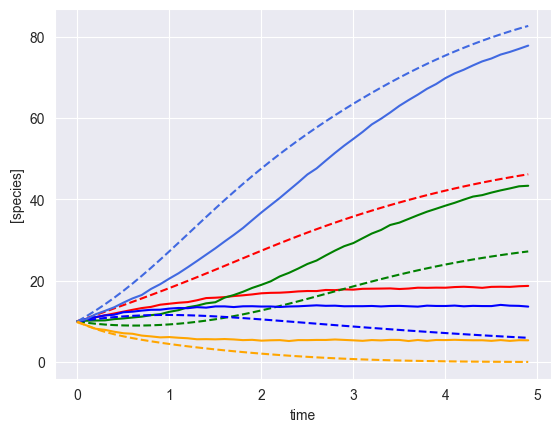

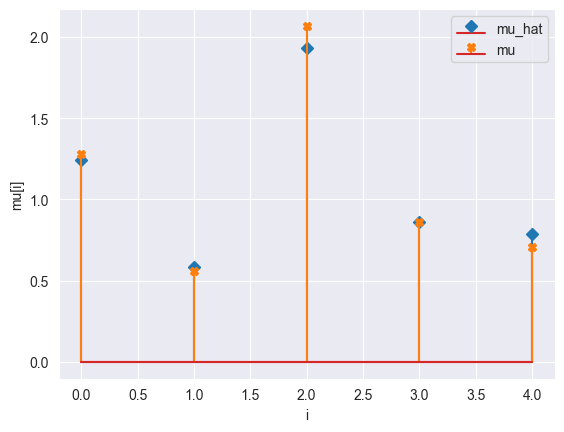

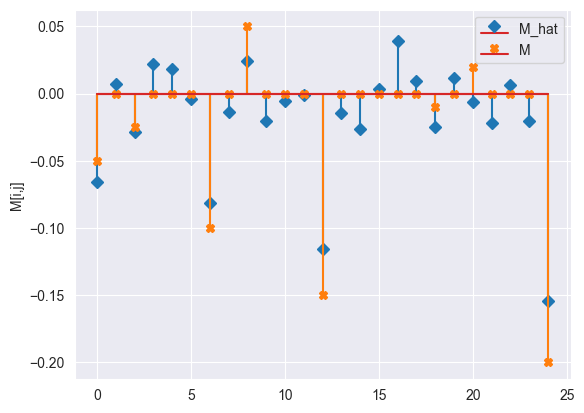

In [18]:
# 4 chains x 100 draws x 5 x 5 species
print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
compare_params(mu=(mu, mu_h), M=(M, M_h) )


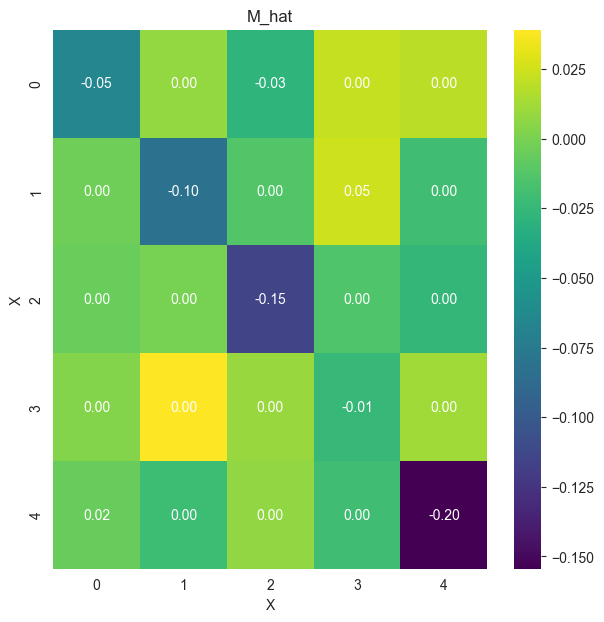

In [19]:
#plot_interaction_matrix(M_h)

infer_h = infergLVbayes(M_h)
matrix = infer_h.plot_interaction_matrix(M = M, M_h =M_h)


### Bayesian inference with shrinkage
Now we will do inference with the Horseshoe prior

In [6]:
nX = num_species
n_obs = times.shape[0] - 1
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX
DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

DA: 20, DA0: 3, N: 47, noise_stddev: 0.1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu_hat, M_ii_hat, c2, tau, lam, M_ij_hat]


Output()

Output()

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 33 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_hat_np shape: (5,)
M_hat_np shape: (5, 5)


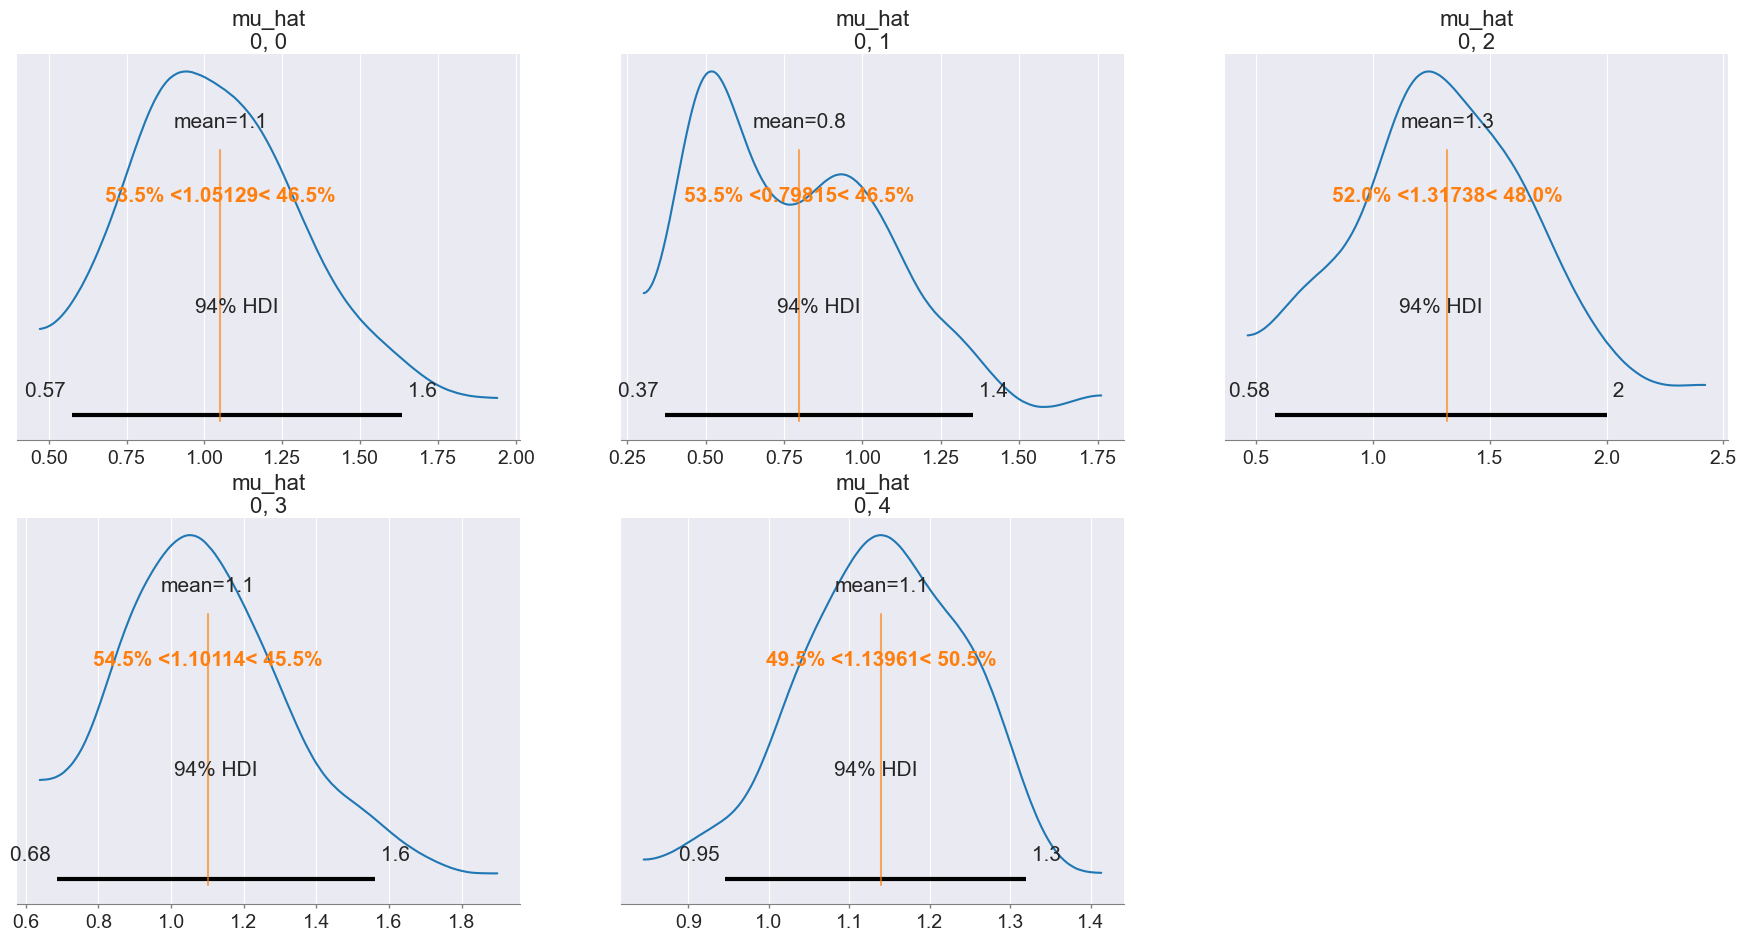

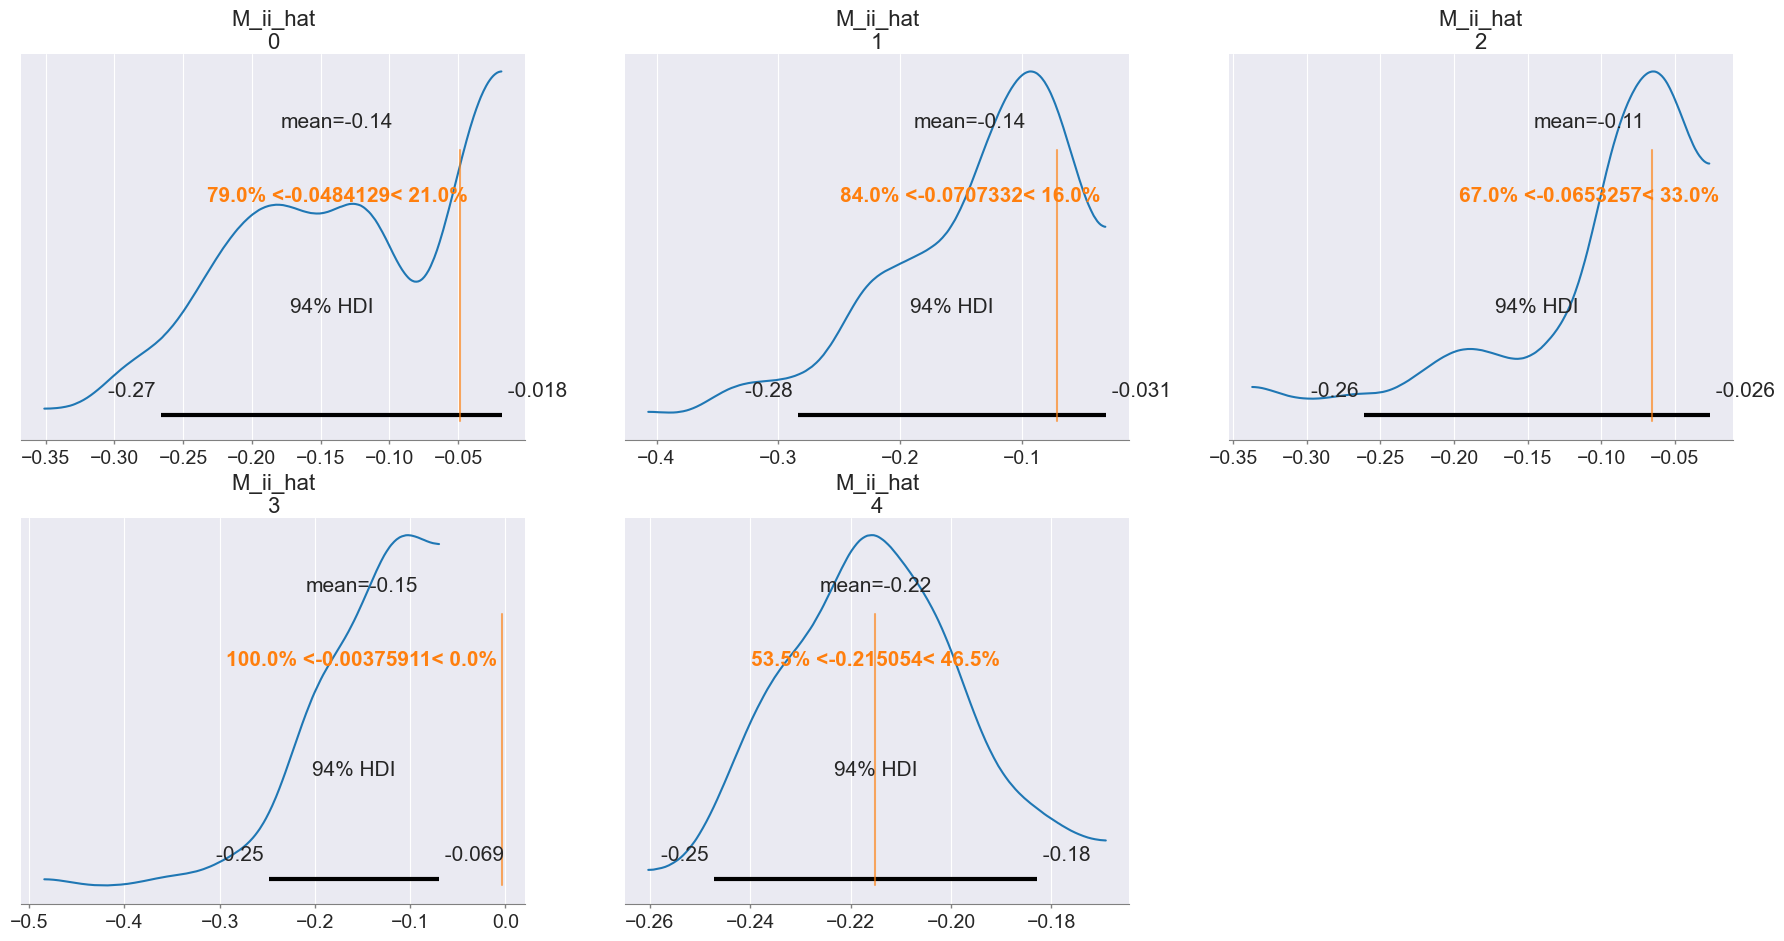

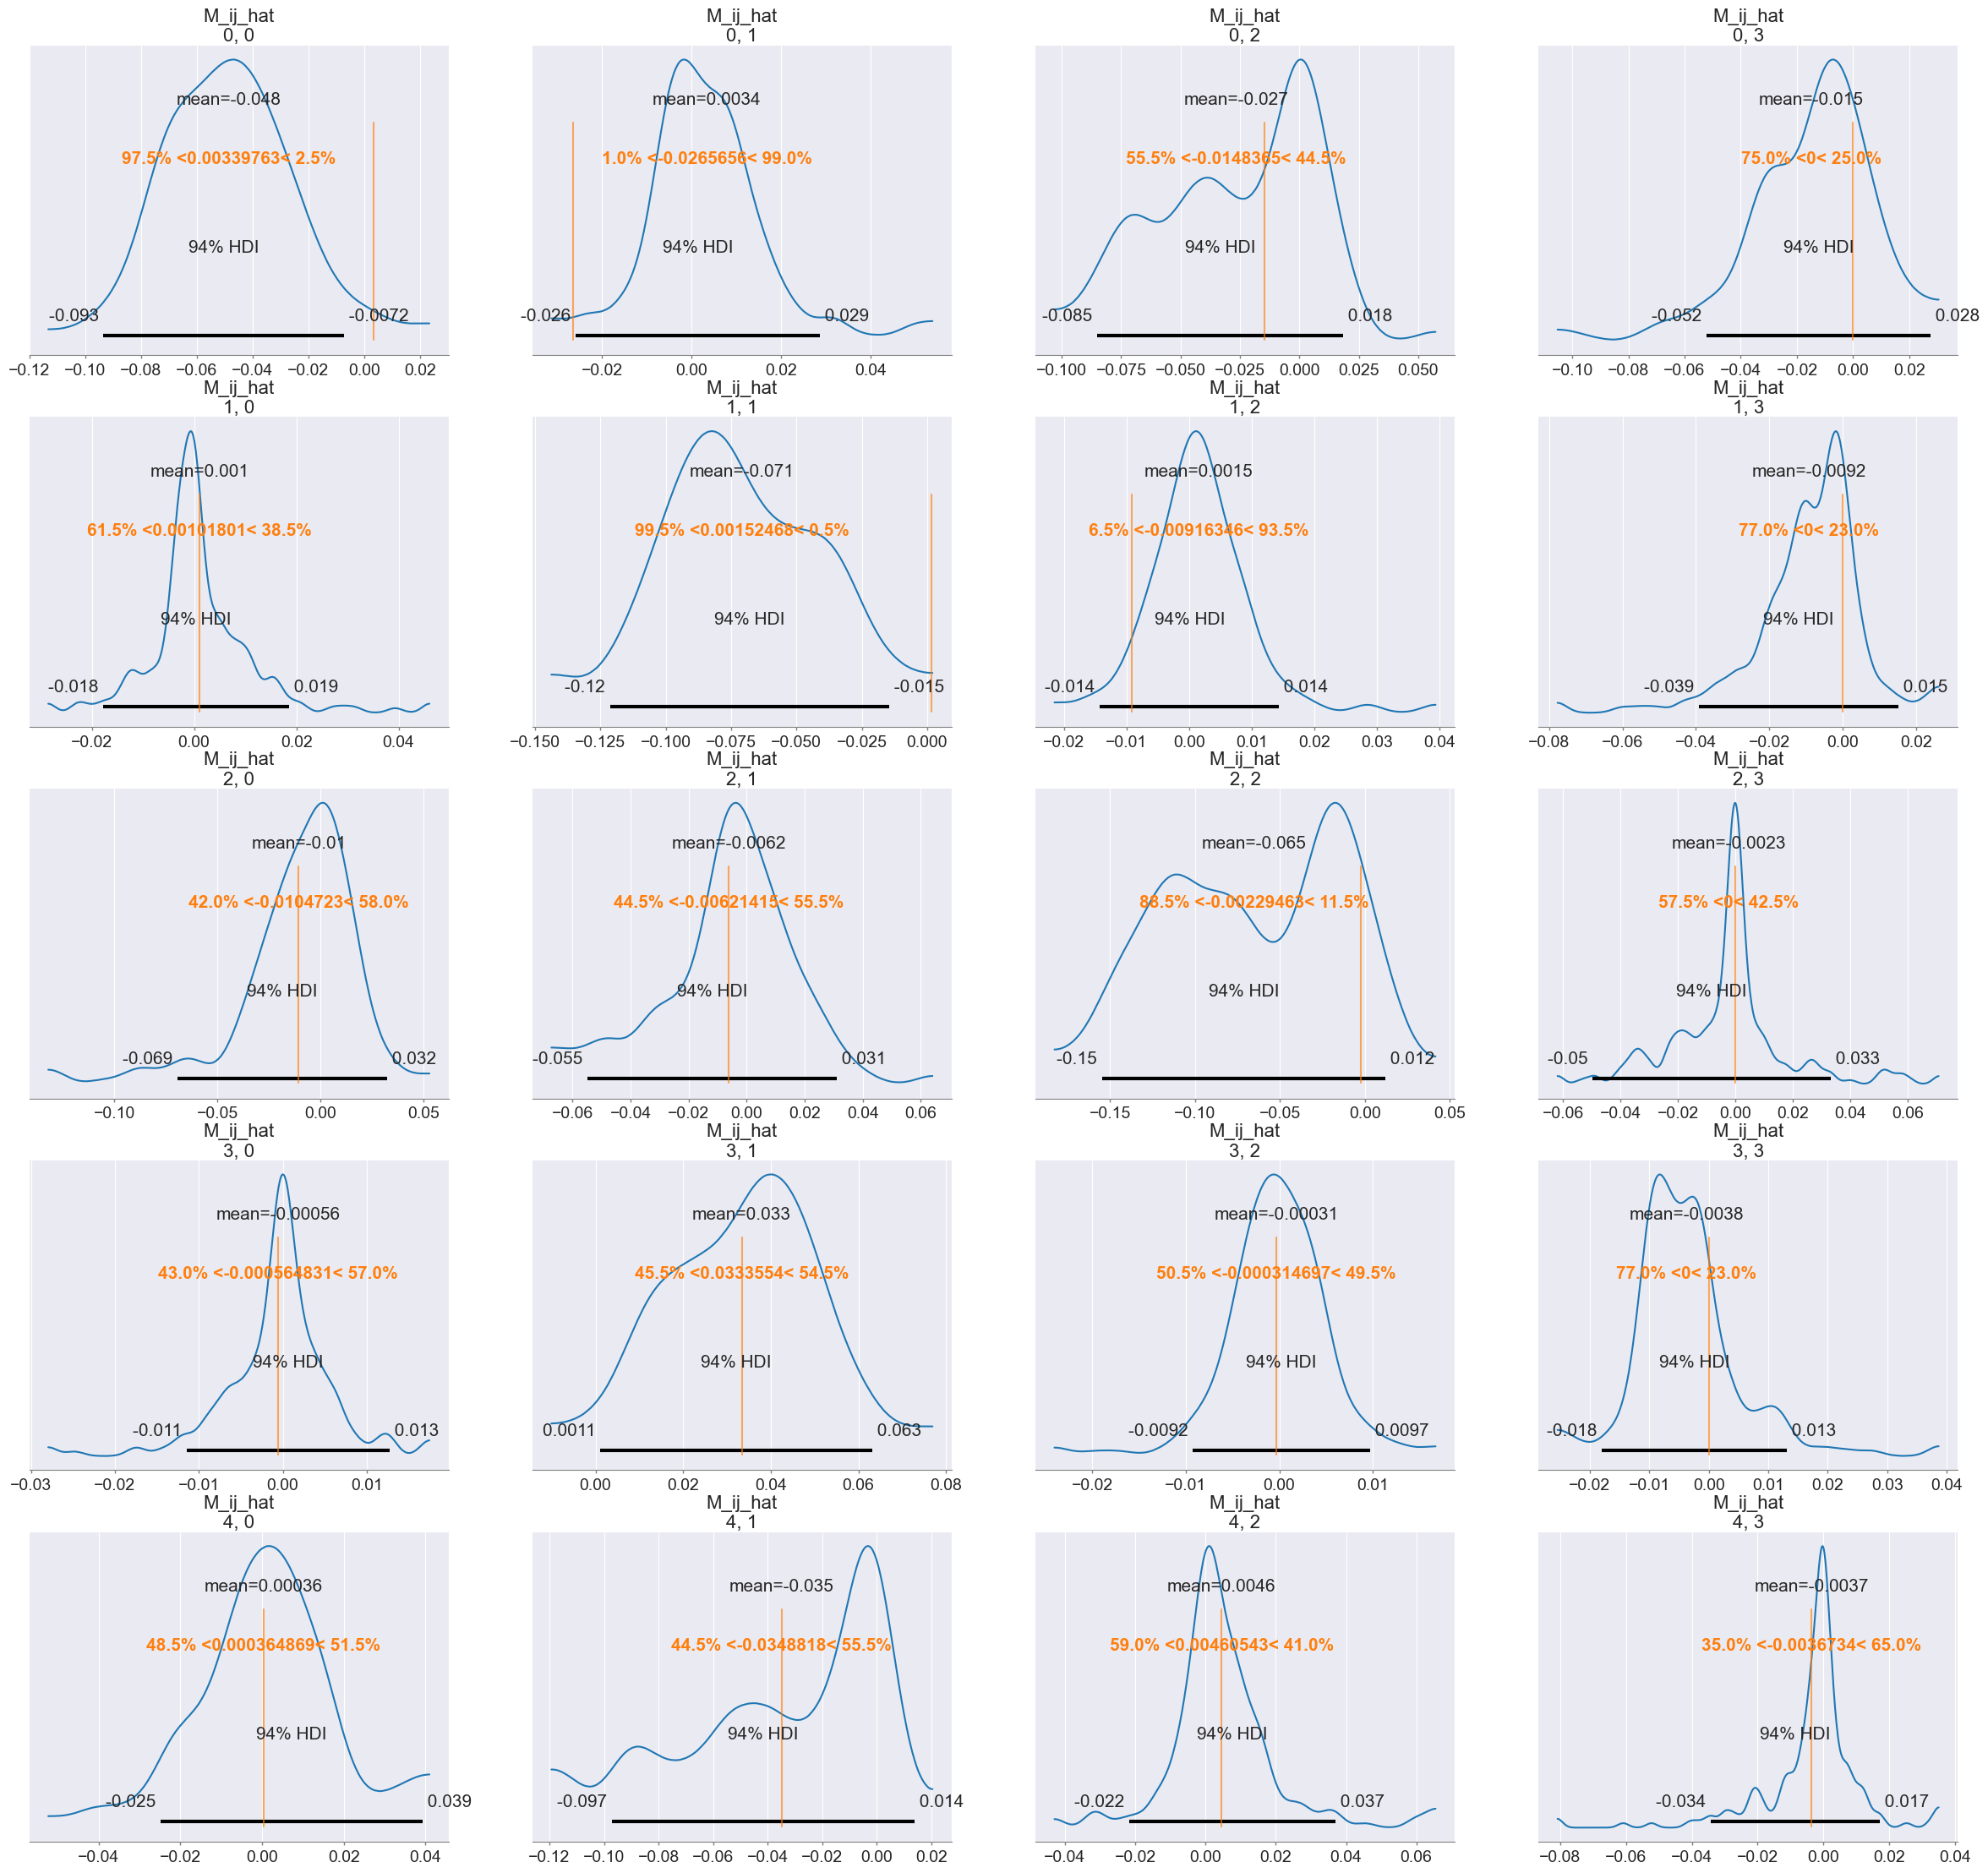

In [7]:
inference = infergLVbayes(X, F, mu, M, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev)
idata = inference.run_bayes_gLV_shrinkage()

In [8]:
# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    1.051  0.288   1.31
mu_hat[0, 1]    0.798  0.305   1.38
mu_hat[0, 2]    1.317  0.396   1.27
mu_hat[0, 3]    1.101  0.237   1.22
mu_hat[0, 4]    1.140  0.102   1.00
M_ii_hat[0]    -0.138  0.080   1.92
M_ii_hat[1]    -0.142  0.076   1.22
M_ii_hat[2]    -0.108  0.072   1.10
M_ii_hat[3]    -0.151  0.062   1.14
M_ii_hat[4]    -0.215  0.017   1.00
M_ij_hat[0, 0] -0.048  0.023   1.24
M_ij_hat[0, 1]  0.003  0.013   1.10
M_ij_hat[0, 2] -0.027  0.032   1.68
M_ij_hat[0, 3] -0.015  0.022   1.13
M_ij_hat[1, 0]  0.001  0.010   1.28
M_ij_hat[1, 1] -0.071  0.030   1.33
M_ij_hat[1, 2]  0.002  0.008   1.05
M_ij_hat[1, 3] -0.009  0.014   1.18
M_ij_hat[2, 0] -0.010  0.028   1.29
M_ij_hat[2, 1] -0.006  0.022   1.08
M_ij_hat[2, 2] -0.065  0.052   1.76
M_ij_hat[2, 3] -0.002  0.020   1.42
M_ij_hat[3, 0] -0.001  0.006   1.22
M_ij_hat[3, 1]  0.033  0.017   1.34
M_ij_hat[3, 2] -0.000  0.005   1.08
M_ij_hat[3, 3] -0.004  0.009   1.17
M_ij_hat[4, 0]  0.000  0.016

'model_posterior.nc'

mu_hat/mu:
[1.03098384 0.7611382  1.30143211 1.0733619  1.14238824]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.05  0.   -0.02 -0.01  0.  ]
 [-0.   -0.08  0.   -0.01  0.  ]
 [-0.01 -0.   -0.07 -0.    0.  ]
 [-0.    0.04 -0.   -0.    0.  ]
 [ 0.   -0.02  0.   -0.   -0.22]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.03098384, 0.7611382 , 1.30143211, 1.0733619 , 1.14238824]), 'M': array([[-4.88558226e-02,  2.23277021e-03, -2.07869715e-02,
        -1.13334125e-02,  0.00000000e+00],
       [-1.48800891e-04, -7.51389106e-02,  1.35182864e-03,
        -7.22191994e-03,  0.00000000e+00],
       [-5.30447904e-03, -4.45161655e-03, -6.89297317e-02,
        -9.98963653e-04,  0.00000000e+00],
       [-1.17879513e-04,  3.58022479e-02, -3.21885

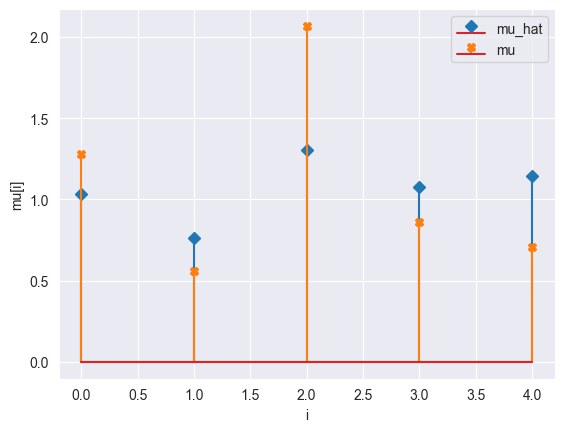

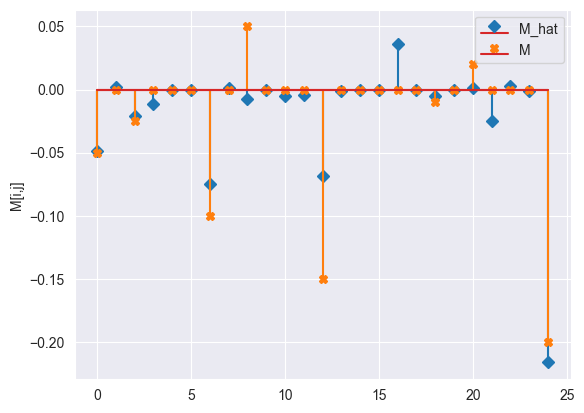

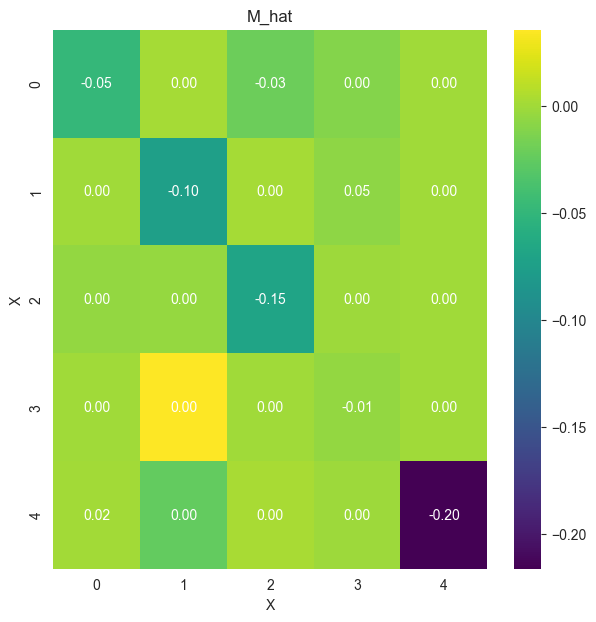

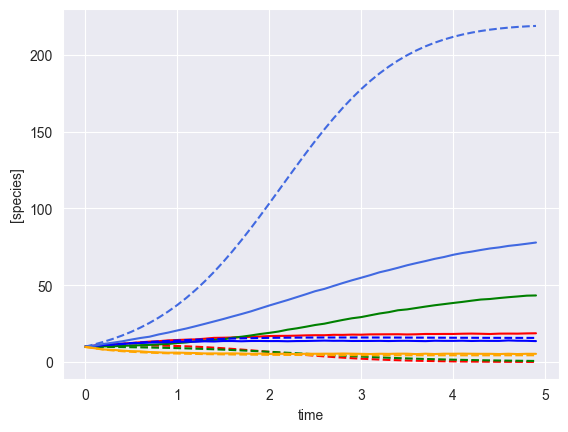

In [9]:
# get posterior medians
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

# compare median posterior values to true values
compare_params(mu=(mu, mu_h), M=(M, M_h) )


#plot_interaction_matrix(M_h)

infer_h = infergLVbayes(M_h)
matrix = infer_h.plot_interaction_matrix(M = M, M_h =M_h)


# Assess fit
predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)
plot_fit_gLV(yobs, yobs_h, times)

### Bayesian inference with shrinkage and a perturbation with unknown interactions
Now we will do inference with the Horseshoe prior for shrinkage but now we include a perturbation (assuming unknown interaction terms). This gives more identifiability

perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0]
Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
epsilon: [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'epsilon': array([[ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.]])}


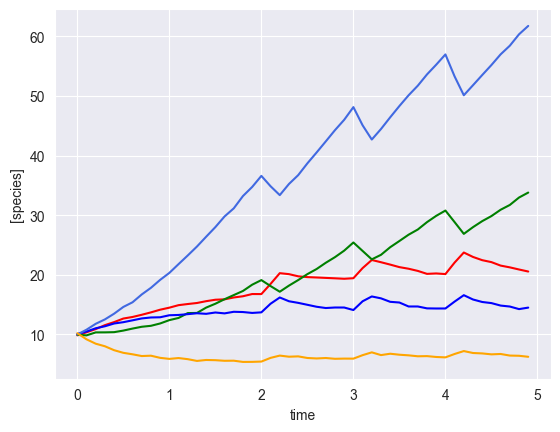

In [10]:
# use all previous definitions of mu, M etc

# construct perturbation matrix
num_perturbations = 1
epsilon = np.zeros([num_species, num_perturbations])
epsilon[:, 0] = [1, -1, 1, -1, 1]

def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

# relinearise
u = np.array([pert_fn(t)[0] for t in times])
u = u.astype(int)
print('perturbation:\n', u)

X, F = linearize_time_course_16S_u(yobs, times, u)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    num_perturbations=num_perturbations,
                    M=M,
                    mu=mu,
                    epsilon=epsilon)
simulator.print_parameters()

yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)

# plot simulation
plot_gLV(yobs, times)

In [11]:
nX = num_species
n_obs = times.shape[0] - 1
noise_stddev = 0.1

# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX
DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, epsilon_hat, M_ii_hat, c2, tau, lam, M_ij_hat]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 76 seconds.
There were 467 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


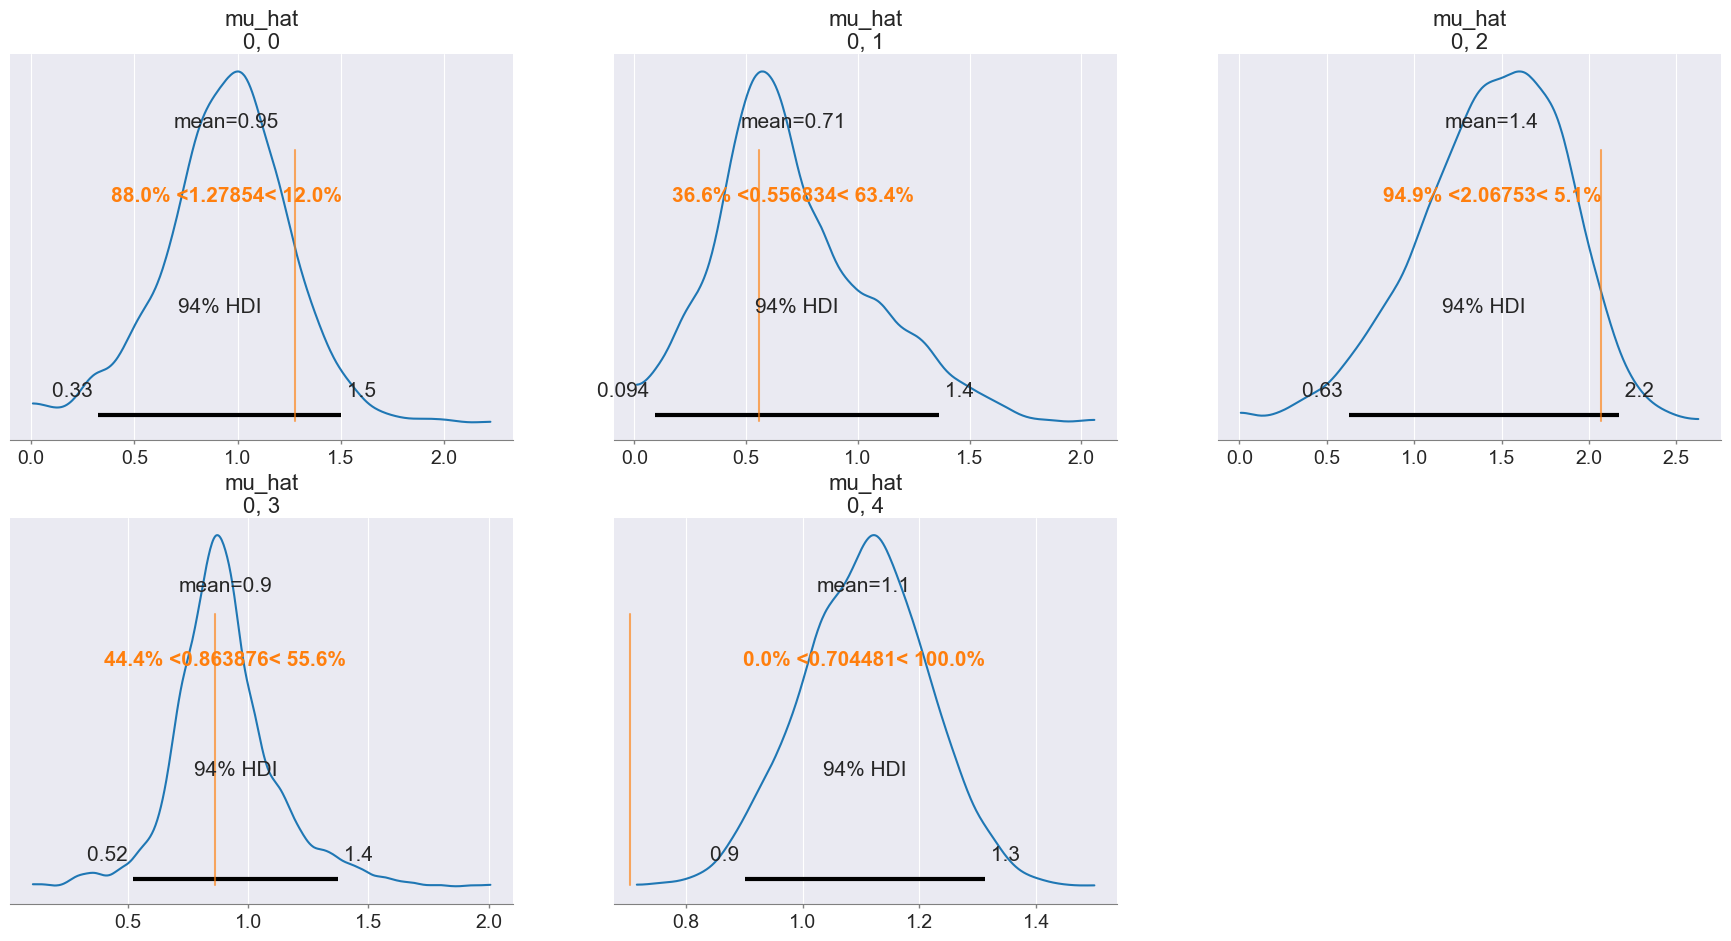

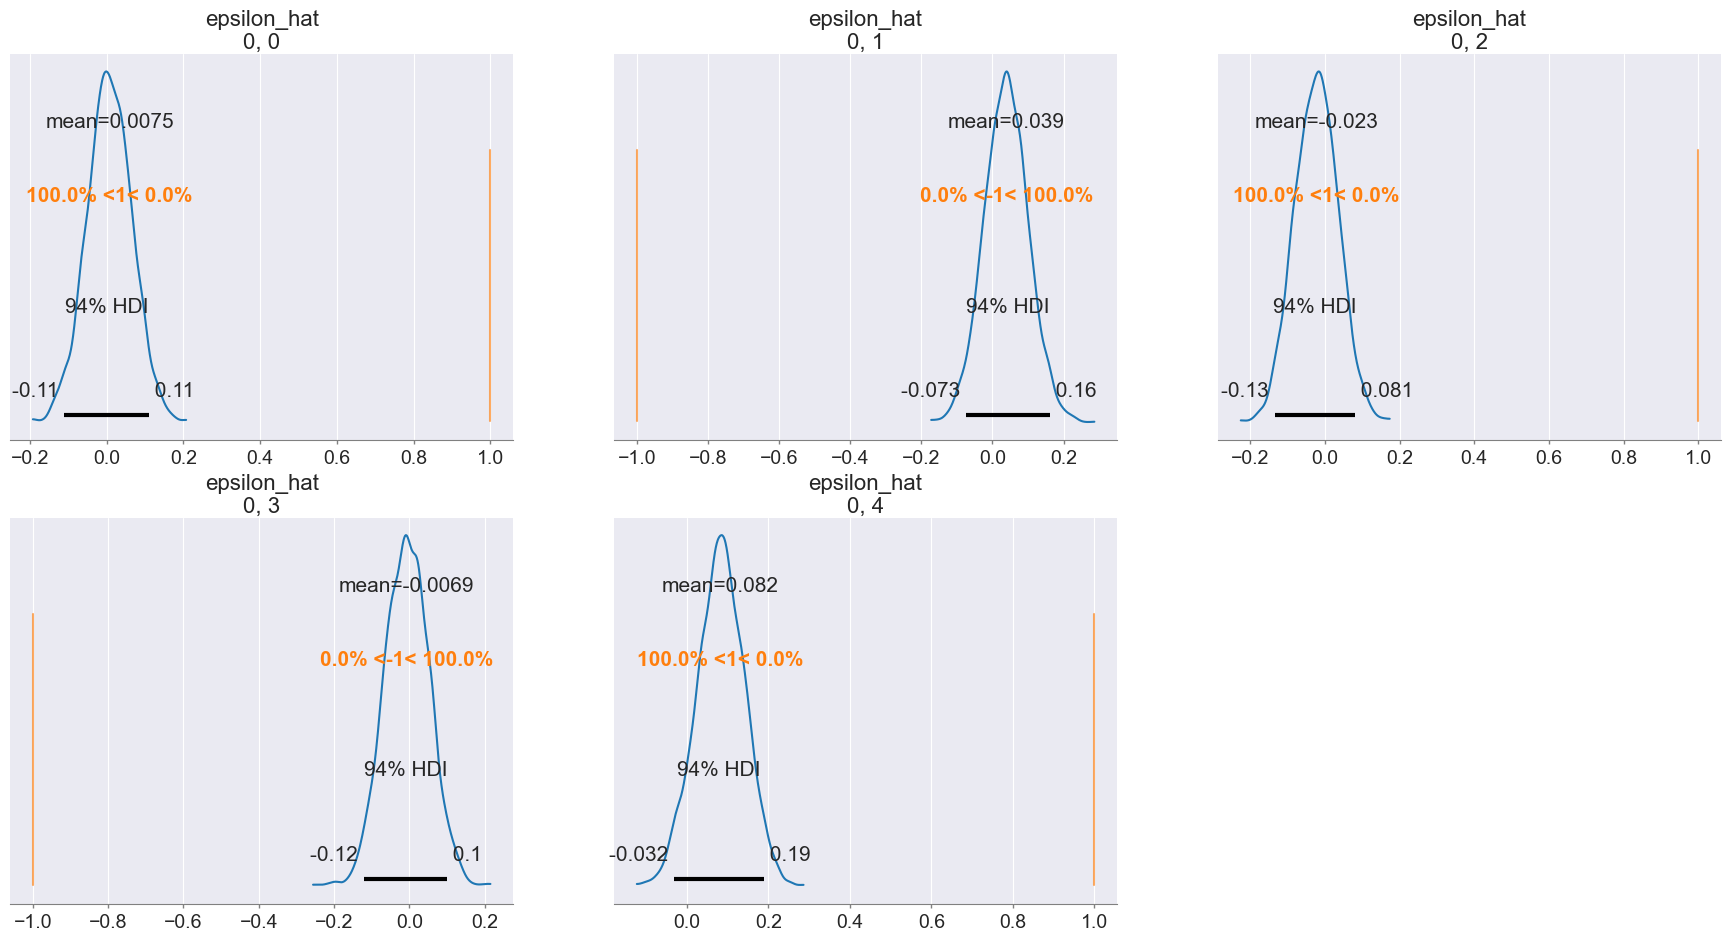

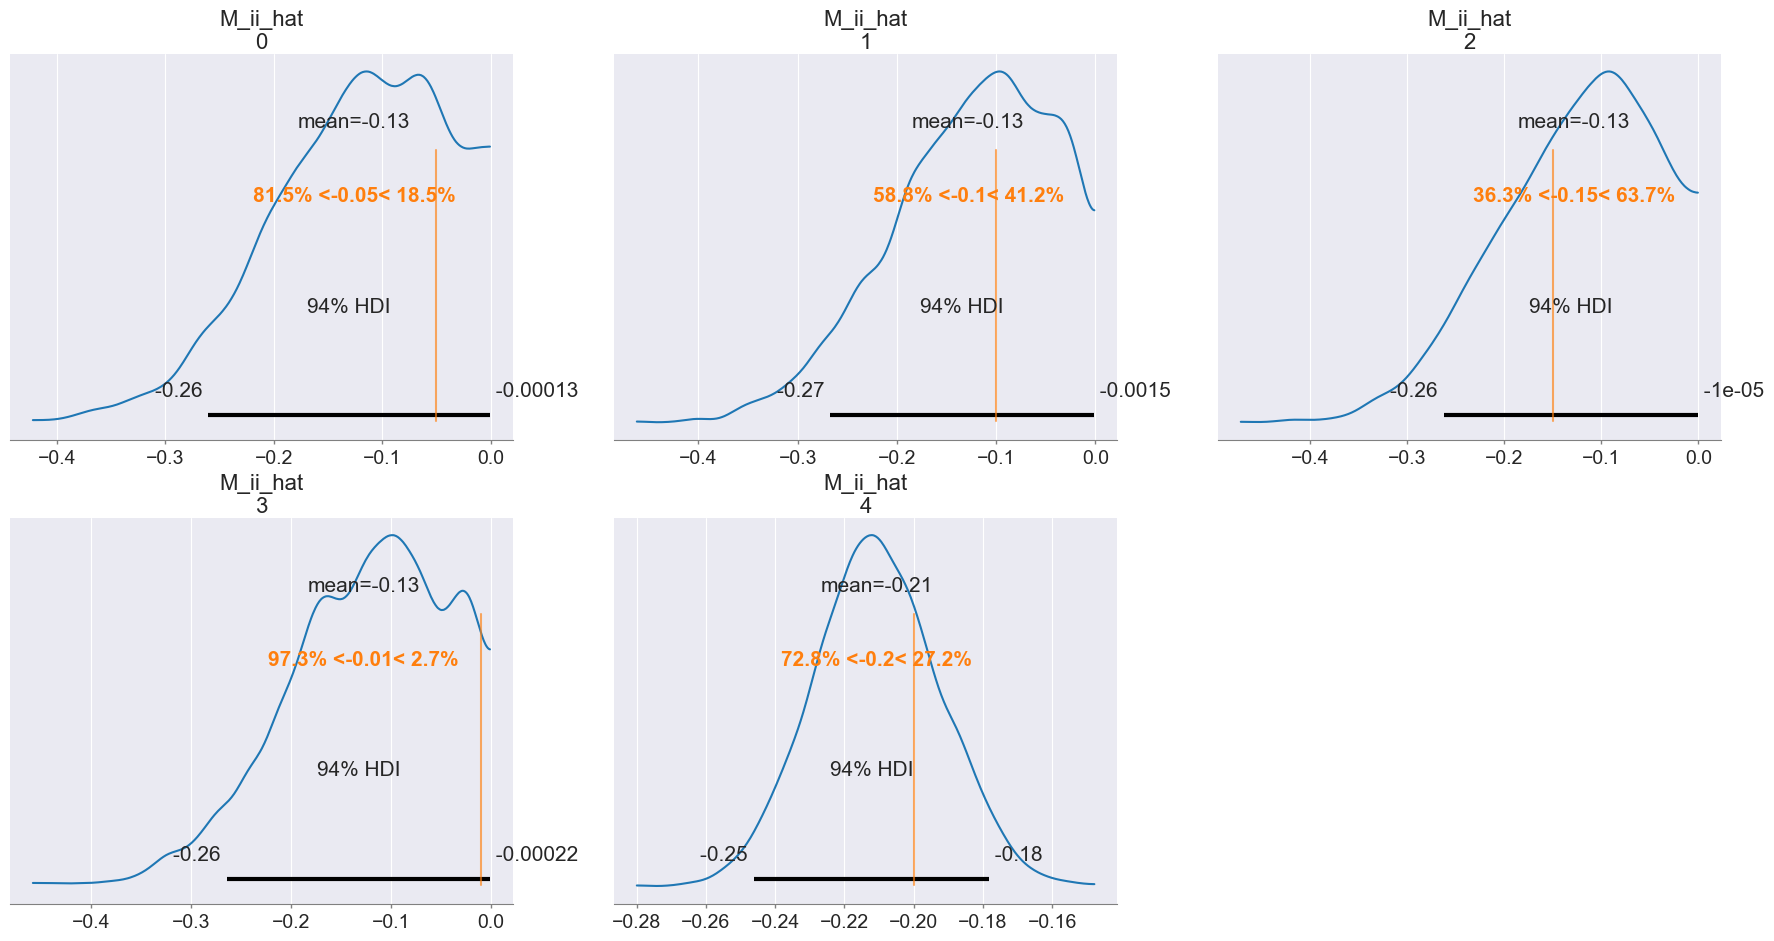

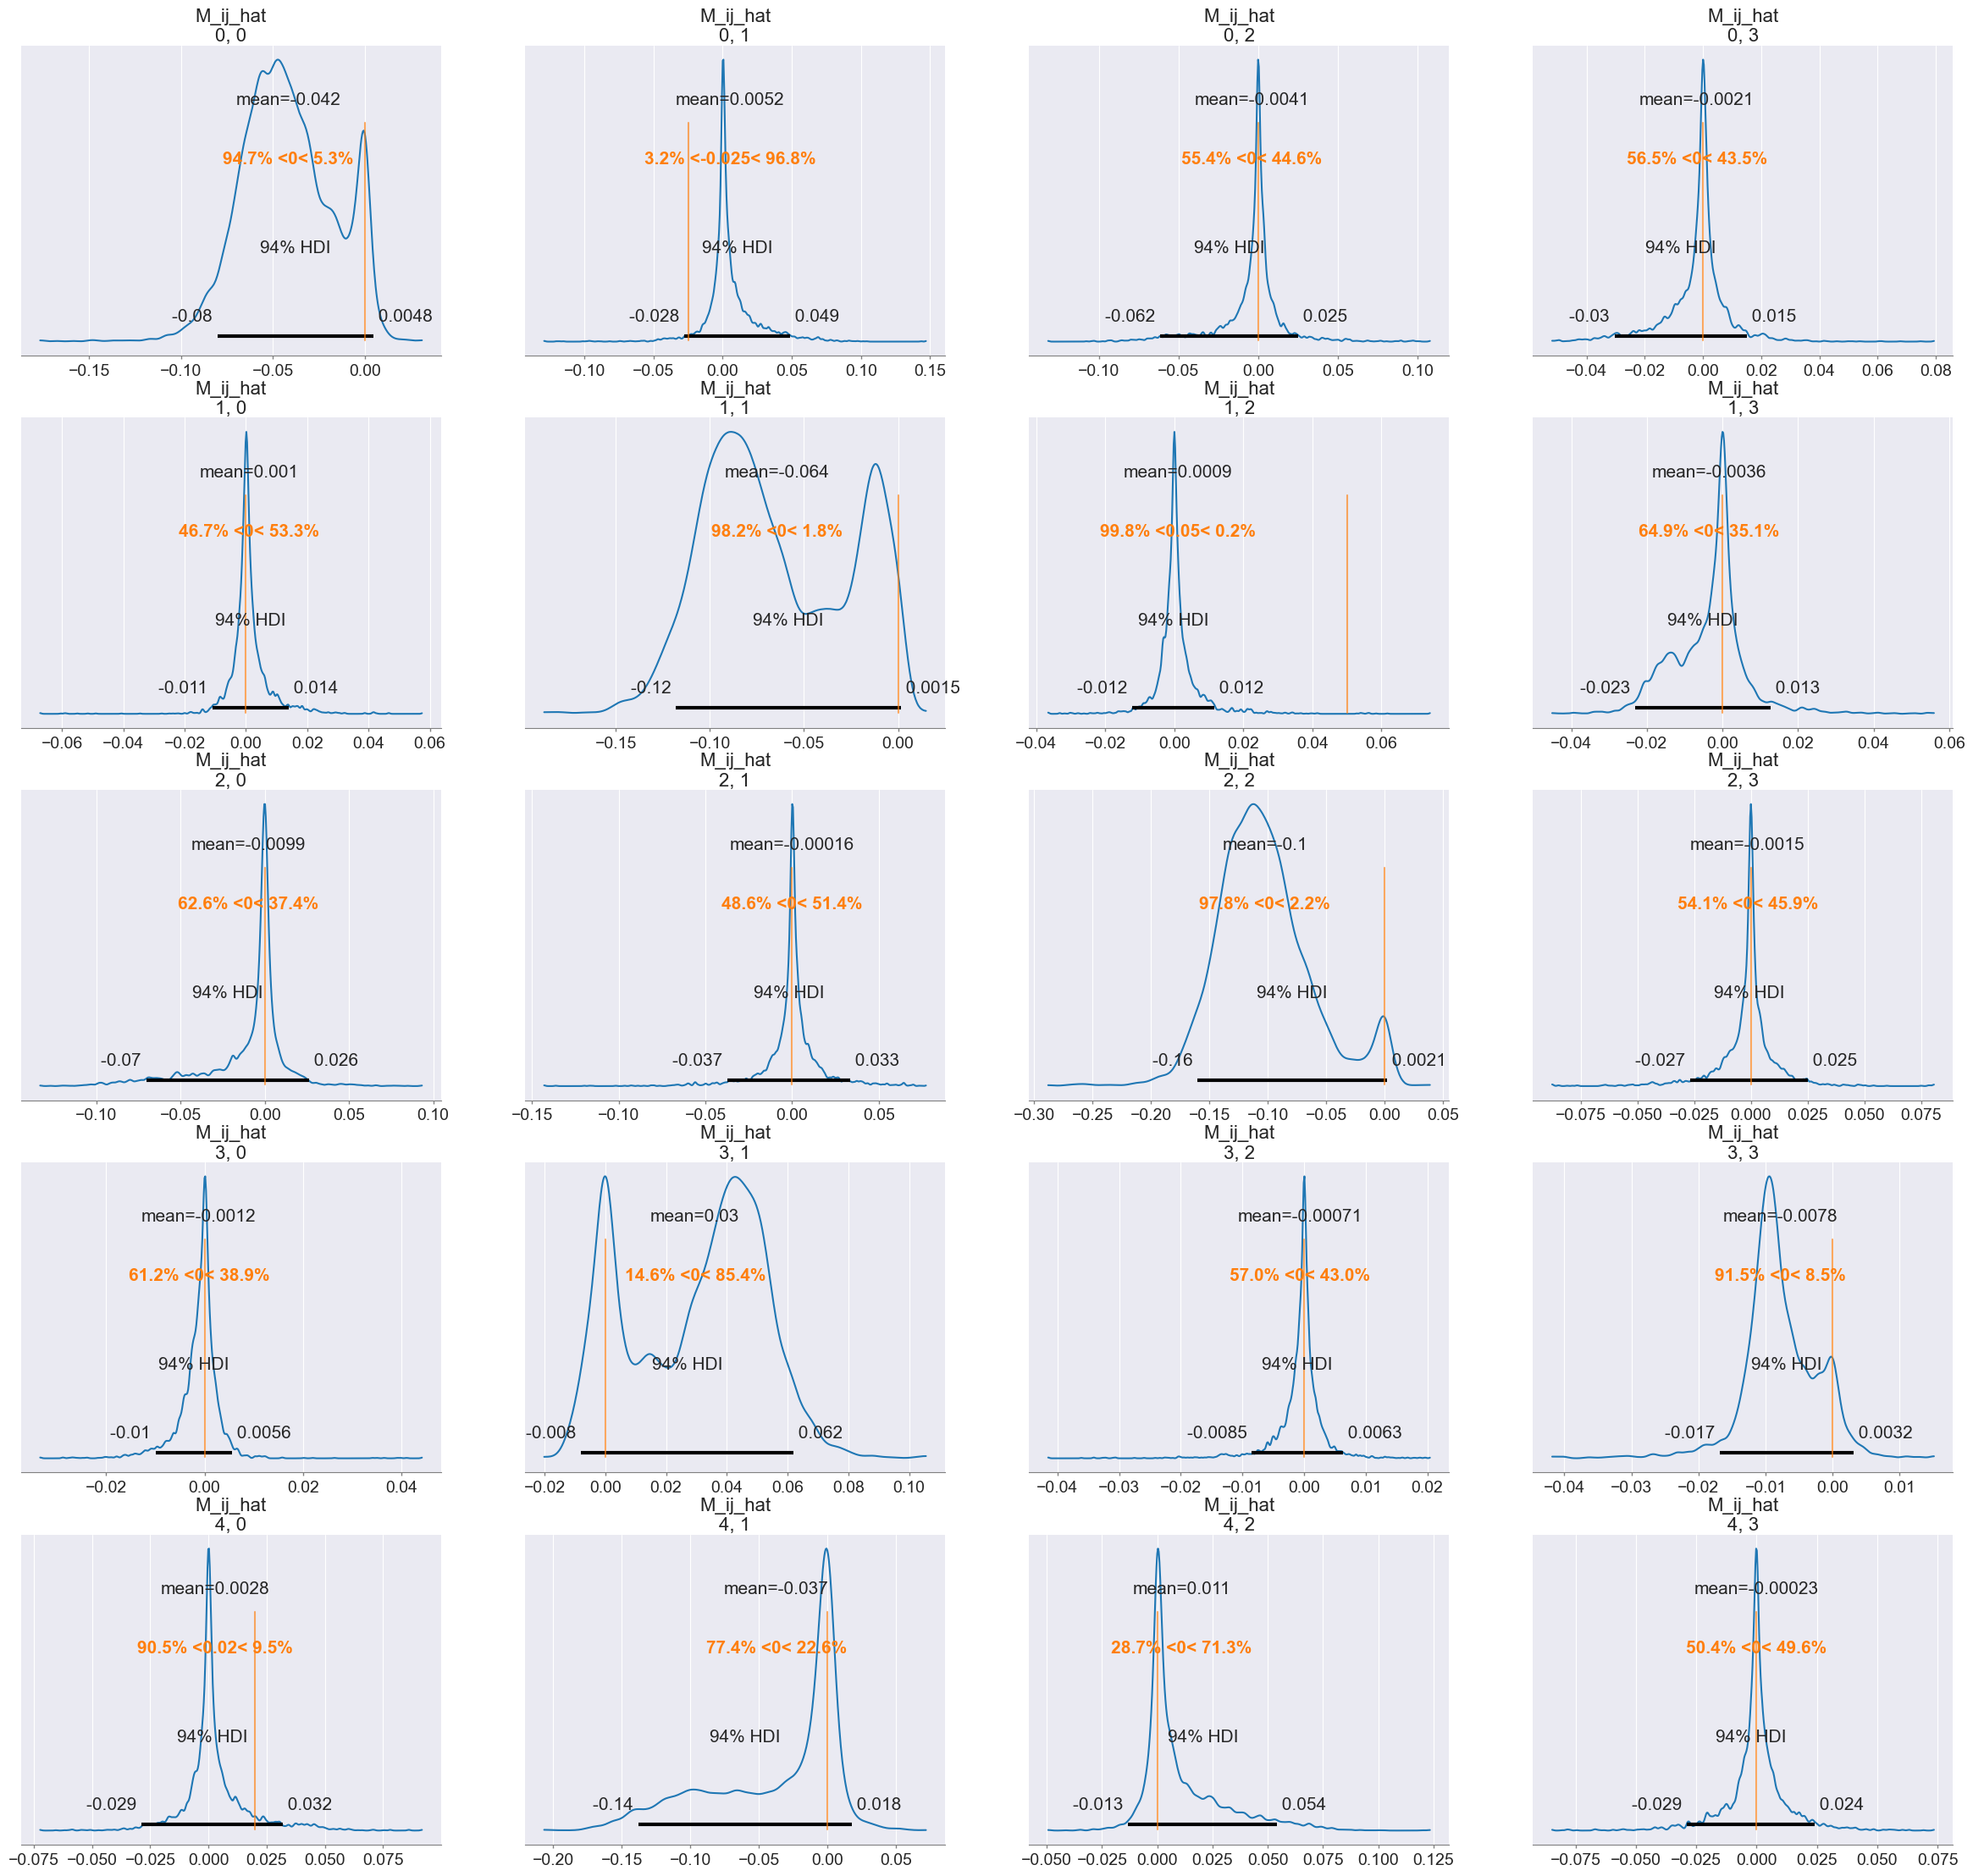

In [12]:
inference = infergLVbayes(X, F, mu, M, DA=DA, DA0=DA0, N=N, noise_stddev=noise_stddev, epsilon=epsilon)
idata = inference.run_bayes_gLV_shrinkage_pert()

In [16]:
# print summary
summary = az.summary(idata, var_names=["mu_hat", "M_hat", "epsilon_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])

# Write posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                    mean     sd  r_hat
mu_hat[0, 0]       1.184  0.218   1.00
mu_hat[0, 1]       0.572  0.177   1.00
mu_hat[0, 2]       1.666  0.301   1.01
mu_hat[0, 3]       0.885  0.137   1.01
mu_hat[0, 4]       1.163  0.121   1.00
M_hat[0, 0]       -0.057  0.021   1.00
M_hat[0, 1]        0.003  0.010   1.01
M_hat[0, 2]       -0.008  0.022   1.01
M_hat[0, 3]       -0.002  0.008   1.01
M_hat[0, 4]        0.000  0.000    NaN
M_hat[1, 0]        0.002  0.007   1.00
M_hat[1, 1]       -0.071  0.036   1.01
M_hat[1, 2]        0.002  0.007   1.01
M_hat[1, 3]       -0.003  0.010   1.01
M_hat[1, 4]        0.000  0.000    NaN
M_hat[2, 0]       -0.014  0.030   1.00
M_hat[2, 1]        0.002  0.013   1.00
M_hat[2, 2]       -0.113  0.039   1.01
M_hat[2, 3]       -0.001  0.010   1.01
M_hat[2, 4]        0.000  0.000    NaN
M_hat[3, 0]        0.000  0.004   1.00
M_hat[3, 1]        0.034  0.018   1.01
M_hat[3, 2]       -0.000  0.004   1.01
M_hat[3, 3]       -0.008  0.005   1.01
M_hat[3, 4]        0.000 

'model_posterior.nc'

In [13]:
type(idata)

arviz.data.inference_data.InferenceData

mu_hat/mu:
[0.94218262 0.64424149 1.50283656 0.89883375 1.10383288]
[1.27853844 0.55683415 2.06752757 0.86387608 0.70448068]

M_hat/M:
[[-0.04  0.   -0.   -0.    0.  ]
 [ 0.   -0.07  0.   -0.    0.  ]
 [-0.   -0.   -0.11 -0.    0.  ]
 [-0.    0.04 -0.   -0.01  0.  ]
 [ 0.   -0.01  0.   -0.   -0.21]]

 [[-0.05   0.    -0.025  0.     0.   ]
 [ 0.    -0.1    0.     0.05   0.   ]
 [ 0.     0.    -0.15   0.     0.   ]
 [ 0.     0.     0.    -0.01   0.   ]
 [ 0.02   0.     0.     0.    -0.2  ]]

e_hat/e:
[[ 0.01]
 [ 0.04]
 [-0.02]
 [-0.01]
 [ 0.08]]

 [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
epsilon: [[ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
epsilon_h: [[ 0.00673812]
 [ 0.03888195]
 [-0.02260897]
 [-0.00662845]
 [ 0.08341004]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 , 

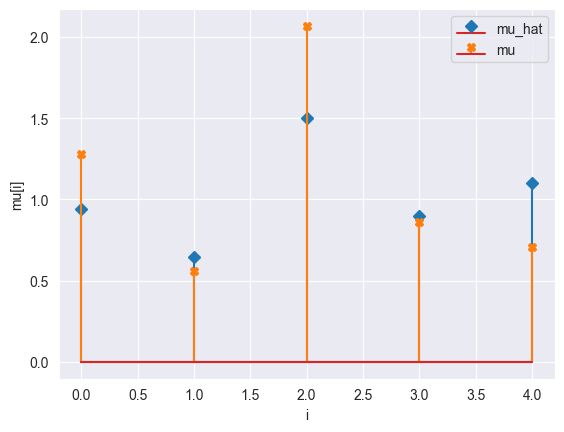

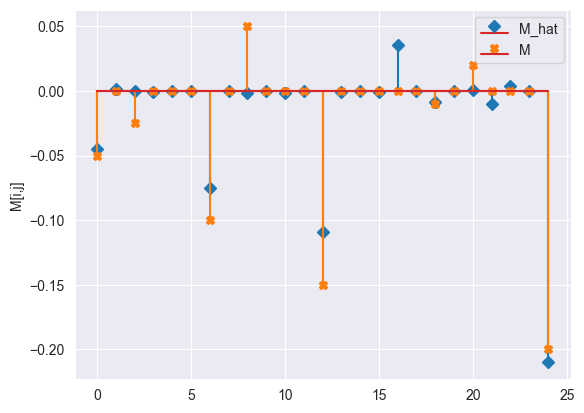

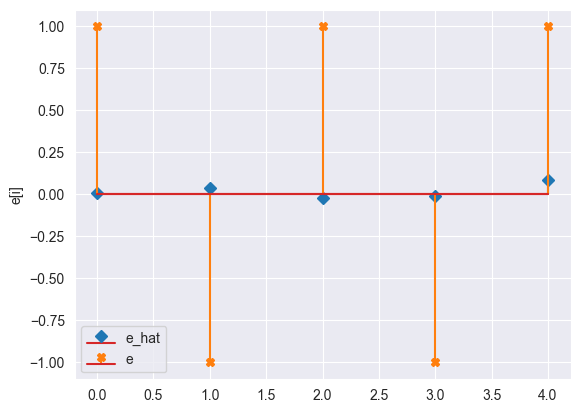

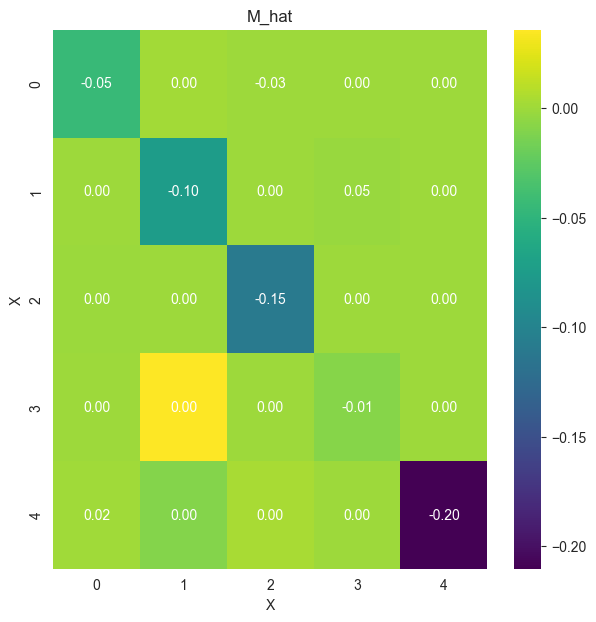

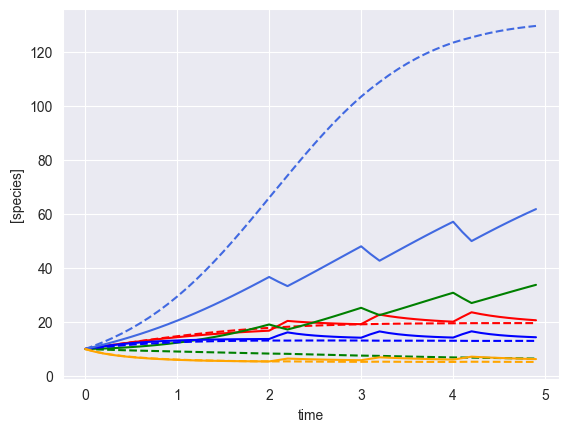

In [15]:
# get posterior medians
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

e_h = np.median(idata.posterior["epsilon_hat"].values, axis=(0, 1))
# reshape e_h so it is the same shape as epsilon
e_h = e_h.reshape(epsilon.shape)

# compare median posterior values to true values
compare_params(mu=(mu, mu_h), M=(M, M_h), e=(epsilon, e_h))

#plot_interaction_matrix(M_h)

infer_h = infergLVbayes(M_h)
matrix = infer_h.plot_interaction_matrix(M = M, M_h =M_h)

# Assess fit
predictor = sim_gLV(num_species=num_species,
                    num_perturbations=num_perturbations,
                    M=M_h,
                    mu=mu_h,
                    epsilon=e_h)

print('epsilon:', epsilon)
print('epsilon_h:', e_h)

yobs, init_species, mu, M, _  = simulator.simulate(times=times, init_species=init_species, u=pert_fn)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species, u=pert_fn)
plot_fit_gLV(yobs, yobs_h, times)